In [41]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [42]:
class Kmeans():
    def __init__(self, k, iters=10):
        self.k = k
        # self.centers = None
        # self.centers_idx = []
        self.iters = iters
        # self.assignments = None
        # self.loss = []
        
    def delete(self, del_idx):
        self.data = np.delete(self.data, del_idx, axis=0)
        return self.run(self.data)
    def run(self, data):
        self.n, self.d = data.shape
        self.data = data
        self.centers = None
        self.centers_idx = []
        self.assignments = None
        self.loss = []
        # 先找中心点
        self.init_centers()
        # 再根据中心点进行聚类
        for _ in range(self.iters):
            self.assignments = np.zeros(self.n).astype(int)
            loss = 0
            D = []
            # 计算所有点到每个中心的距离
            for center in self.centers:
                d = np.linalg.norm(data - center, axis=1, ord=2)
                D.append(d)
            # 到哪个中心距离最短就属于哪个cluster
            self.assignments = np.argmin(D, axis=0)
            # 损失函数的定义是
            loss = np.sum(np.min(D, axis=0)**2)/self.n
            # 对每个聚类中心更新，使用聚类内所有点的平均值
            for i in range(self.k):
                cluster = data[self.assignments == i]
                self.centers[i] = np.sum(cluster, axis=0) / len(cluster)
                # print("center:",self.centers[i])
            self.loss.append(loss)
        return self.centers, self.assignments, self.loss
    
    def init_centers(self):
        # 随机找到一个中心点
        idx = np.random.choice(self.n)
        self.centers_idx.append(idx)
        centers = [self.data[idx,:]]
        for i in range(1,self.k):
            D = []
            for center in centers:
                # 计算每个点到这个聚类中心的距离
                d = np.linalg.norm(self.data - center, axis=1, ord=2)
                # d = np.sum((data - center)**2, axis = 1)
                D.append(d)
            # 一个很严重的问题，numpy的数组操作好多都没有，我该怎么用呢？
            # D储存的就是每个点到每个聚类中心的距离
            D = np.array(D)
            # P是每个点到最近的聚类中心的距离长度
            P = np.min(D, axis=0)
            # print("P:", P.shape, "  D:", D.shape)
            ## 转化成概率
            #P = P / np.sum(P)
            # next_idx = np.random.choice(self.n, p=P)
            # 直接把距离最大的给筛选出来，是否需要在距离前几名中进行随机选取？，不然会导致噪声影响太大
            next_idx = np.argmax(P)
            self.centers_idx.append(next_idx)
            centers.append(self.data[next_idx, :])
            #print(P.shape, centers)
        self.centers = np.array(centers)

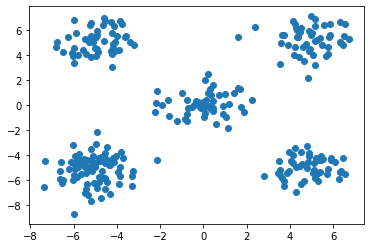

In [51]:
N=10
covariance = [[1, 0.1], [0.1, 1]]
clusters_params = [{ "mean": [-5,5], "cov": covariance, "size": 5*N },
                   { "mean": [0,0], "cov": covariance, "size": 5*N },
                   { "mean": [5,5], "cov": covariance, "size": 5*N },
                   { "mean": [5,-5], "cov": covariance, "size": 5*N },
                   { "mean": [-5,-5], "cov": covariance, "size": 8*N }]
def sample_gmm(clusters_params):
    clusters = []
    for param in clusters_params:
        cluster = np.random.multivariate_normal(mean=param["mean"], cov=param["cov"], size=param["size"])
        clusters.extend(cluster)
    return np.array(clusters)

data = sample_gmm(clusters_params)
plt.scatter(x=data[:,0], y=data[:,1])

In [43]:
class DCNode(Kmeans):
    def __init__(self, k, iters=10):
        Kmeans.__init__(self, k=k,iters=iters)
        # 继承自Kmeans，添加children和parent，用于构造树 
        self.children = []
        self.parent = None
        # 当前节点存储的数据
        self.node_data = set()
        self.data_prop = set()
        
class DCKmeans():
    def __init__(self, ks, widths, iters=10):
        self.ks = ks
        self.widths = widths
        self.dc_tree = self.init_tree(ks, widths, iters)
        
        self.data_partion_table = dict()
        self.data = dict()
        self.dels = set()
        self.height = len(self.dc_tree)
        for i in range(self.height):
            self.data[i] = None
        
    def run(self, data, assignments=False):
        self.n, self.d = data.shape
        data_layer_size = self.n
        # 从height-1减到0，这是为了将储存数据的self.data[i]设置成相应的0矩阵
        for i in range(self.height-1, -1, -1):
            self.data[i] = np.zeros((data_layer_size, self.d))
            print(f"self.data[{i}].shape:{self.data[i].shape}; data.shape")
            data_layer_size = self.ks[i] * self.widths[i]
        # 
        num_leaves = len(self.dc_tree[-1])
        # 对每个数据点，随机抽取一个叶子节点，然后塞到里面去
        # TODO 考虑不用for循环
        # 所有数据点的表示都使用下标来表示
        for i in range(self.n):
            leaf_id = np.random.choice(num_leaves)
            # 维护划分表，记录每个数据点属于哪个叶子节点
            self.data_partion_table[i] = leaf_id
            # leaf维护自己当前存储的数据点
            leaf = self.dc_tree[-1][leaf_id]
            leaf.node_data.add(i)
            # 前面初始化过data[k]，此时将data[k]的第i行设置为第i个数据
            self.data[self.height-1][i] = data[i]
        for h in range(self.height-1, -1, -1):
            c = 0
            for w in range(self.widths[h]):
                subproblem = self.dc_tree[h][w]
                # 将当前高度height/层数level 进行聚类
                subproblem.run(self.data[h])
                if subproblem.parent == None:
                    # 到根节点了
                    self.centers = subproblem.centers
                else:
                    for c_id in range(len(subproblem.centers)):
                        # ?这段代码没看懂
                        subproblem.data_prop.add(c)
                        subproblem.parent.node_data.add(c)
                        self.data[h-1][c] = subproblem.centers[c_id]
                        c +=1
        # 如果要求assignments，退化到原始的Kmeans算法；所以每次都只是按照不返回assignments实验
        return self.centers
        
    
    def init_tree(self, ks, widths, iters):
        print("init_tree:", ks, widths, iters)
        tree = [[DCNode(ks[0],iters)]] # 根节点
        for i in range(1, len(widths)):
            k = ks[i]
            assert widths[i] % widths[i-1] == 0, "Inconsistent widths in tree"
            # 下一层节点的数量的整数倍
            merge_factor = int(widths[i] / widths[i-1]) 
            level = []
            for j in range(widths[i-1]):
                parent = tree[i-1][j]
                for _ in range(merge_factor):
                    child = DCNode(k, iters=10)
                    child.parent = parent
                    parent.children.append(child)
                    level.append(child)
            tree.append(level)
        return tree 

init_tree: [5, 5] [1, 16] 10
self.data[1].shape:(280, 2); data.shape
self.data[0].shape:(80, 2); data.shape
[[ 0.04754262  0.09595668]
 [-5.09381807 -5.16236764]
 [ 4.91838968  5.24959691]
 [-4.90832108  5.14049151]
 [ 4.83551247 -4.96698171]]


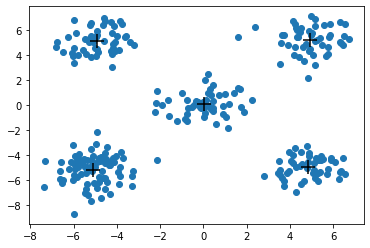

In [52]:
dckmeans=DCKmeans([5,5], [1,16])
centers = dckmeans.run(data.copy(),assignments=False)
print(centers)
plt.scatter(x=data[:,0], y=data[:,1])
plt.scatter(x=centers[:,0], y=centers[:,1], c='k', marker='+', s=180)

In [45]:
def show_cluster(centers, assignments, data):
    plt.scatter(x=data[:,0], y=data[:,1], c=assignments)
    plt.scatter(x=centers[:,0], y=centers[:,1], c='k', marker='+', s=180)

In [28]:
def online_deletion_stream(num_dels, model):
    begin = time.time()
    for i in range(num_dels):
        dr = np.random.choice(model.n)
        model.delete(dr)
        # print(f"process deletion request # {i+1}, cost time: {time.time()-begin}")
    end = time.time()
    print(f"Total time to process {num_dels} deletions is {end - begin}")

In [29]:
online_deletion_stream(20, kmeans)

Total time to process 20 deletions is 0.10602998733520508
